In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
from numpy.testing import assert_allclose
from mcfit.transforms import *

font = {'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

import os 
path_to_class_sz = os.getcwd() + '/../../class_sz/'

# a simple conversion from cl's to dl's
def l_to_dl(lp):
    return lp*(lp+1.)/2./np.pi

Metal device set to: Apple M1 Pro


2023-04-06 01:18:21.122506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-06 01:18:21.122619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
cosmology = {
     'h' : 0.6774,
     'Omega_b' : 0.04860,
     'Omega_cdm' : 0.315-0.04860,
     'sigma8' : 0.8159,
     'n_s' : 0.9667,

    'N_ncdm' : 1,
    'N_ur' : 0.00641,
    'deg_ncdm' : 3,
    'm_ncdm' : 0.02,
    'T_ncdm' : 0.71611

}

fast_cosmology = {
'H0': cosmology['h']*100.,
'omega_b': cosmology['Omega_b']*cosmology['h']**2,
'omega_cdm': cosmology['Omega_cdm']*cosmology['h']**2,
# 'sigma8': 0.831,
'ln10^{10}A_s': 3.024551967771024,
'n_s': cosmology['n_s'],
'tau_reio' : 0.055,

}


0.9999999999999999
0.009622278143990333
1.0000000000000002


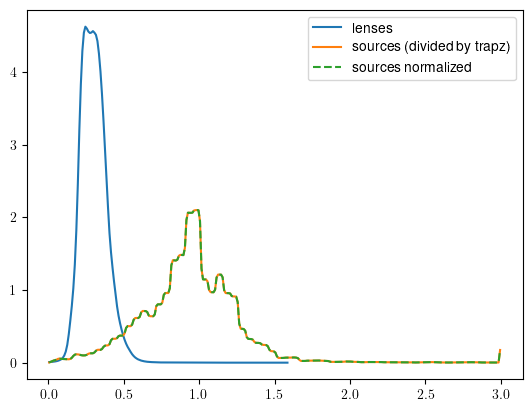

In [3]:
z , nz_lenses = np.loadtxt(path_to_class_sz+'class_sz_auxiliary_files/nz_lens_bin1.txt',unpack=True)
plt.plot(z,nz_lenses,label='lenses')
print(np.trapz(nz_lenses,z))
z , nz_sources = np.loadtxt(path_to_class_sz+'class_sz_auxiliary_files/nz_source_bin4.txt',unpack=True)
plt.plot(z,nz_sources/np.trapz(nz_sources,z),label='sources (divided by trapz)')
z , nz_sources_normalized = np.loadtxt(path_to_class_sz+'class_sz_auxiliary_files/nz_source_normalized_bin4.txt',unpack=True)
plt.plot(z,nz_sources_normalized,label='sources normalized',ls='--')

print(np.trapz(nz_sources,z))
print(np.trapz(nz_sources_normalized,z))
plt.legend()

In [34]:
%%time

M = Class()
# M.set(cosmology)
M.set(fast_cosmology)
M.set({
'output':'gamma_gal_gallens_1h,gamma_gal_gallens_2h',
'ell_max' : 5e5,
'ell_min' : 2,
'dlogell':0.1,
    
'ndim_masses': 80,
'ndim_redshifts':80,
    
'mass function':'T08M200c',


'M_min':1e11, # Msun/h
'M_max':1e15, # Msun/h
'mass_epsrel': 1e-3,
'mass_epsabs': 1e-40,
    
'z_min':1e-5, 
'z_max': 2.,
'redshift_epsrel': 0.5e-3,
'redshift_epsabs': 1e-40,

'delta for galaxies':'200c',
'delta for matter density':'200c',
    
'concentration parameter':'fixed',
    
#     logMmin = 11.57
#     sig_logM = 0.17
#     logM1 = 12.75
#     alpha_g = 0.99
#     fcen = 0.9
#     rmax_r200c = 1.0 # max gal /r200c
#     rmax_rvir = 1.0 # 
#     rsg_rs = 1.0  # concentration galaxies same as nfw
    
'M0_HOD': 0.,
'M_min_HOD':10.**11.57, #Msun/h
'M1_prime_HOD':10.**12.75, #Msun/h
    
'sigma_log10M_HOD':0.17,
'alpha_s_HOD':0.99,
    
'x_out_truncated_nfw_profile_satellite_galaxies':1., # so corresponds to 1xr200c
'csat_over_cdm' : 1.,

'f_cen_HOD': 1.,


    
    
'Delta_z_lens':0.00,
'Delta_z_source':0.00,
    
'galaxy_sample' : 'custom',
'full_path_to_dndz_gal' : path_to_class_sz+'class_sz_auxiliary_files/nz_lens_bin1.txt', # lens galaxies
'full_path_to_source_dndz_gal' : path_to_class_sz+'class_sz_auxiliary_files/nz_source_normalized_bin4.txt', # source galaxies

'N_samp_fftw':1024, #precision parameter for the bessel transform to theta space
'l_min_samp_fftw' : 1e-8,
'l_max_samp_fftw' : 1e8,
    
'hm_consistency' : 1,
# 'ndim_redshifts': 200,
# 'ndim_masses': 500,
    
'use_pknl_in_2hterms': 0,

    
# 'P_k_max_h/Mpc':5e1,
'non_linear':'halofit'
})
M.compute_class_szfast()
# M.compute()

CPU times: user 5.66 s, sys: 119 ms, total: 5.78 s
Wall time: 934 ms


In [35]:
# As = M.get_current_derived_parameters(['A_s'])['A_s']
# np.log(1e10*As)

In [36]:
gamma_t_thetas = np.asarray(M.gamma_ggamma()['thetas'])
gamma_t_1h = np.asarray(M.gamma_ggamma()['1h'])
gamma_t_2h = np.asarray(M.gamma_ggamma()['2h'])
m_gammat = 0. 

cl_g_gamma_ell = np.asarray(M.cl_ggamma()['ell'])
cl_g_gamma_1h = np.asarray(M.cl_ggamma()['1h'])
cl_g_gamma_2h = np.asarray(M.cl_ggamma()['2h'])

m_gammat = 0.

In [39]:
%%time
from mcfit.transforms import *
x = np.logspace(-6, 6, num=600, endpoint=False)
fac = cl_g_gamma_ell*(cl_g_gamma_ell+1.)/2./np.pi
cltt = cl_g_gamma_1h/fac+cl_g_gamma_2h/fac
clttfunc = interp1d(cl_g_gamma_ell,cltt,kind='cubic', axis=-1, copy=True, bounds_error=False, fill_value=1e-100, assume_sorted=False)

# th_z21, gammat_z21_1h, gammat_z21_2h, gammat_z21_tot  = np.loadtxt('/Users/boris/Downloads/cl_gk_bin14_v2.txt',unpack=True)
# #fac = th_z21*(th_z21+1.)/2./np.pi
# cltt = gammat_z21_tot#/fac
# clttfunc = interp1d(th_z21,cltt,kind='cubic', axis=-1, copy=True, bounds_error=False, fill_value=1e-100, assume_sorted=False)

F = clttfunc(x)
H = Hankel(x, nu=2, q=1, N=1024, lowring=True)
y, G = H(F, extrap=True)
# cltt = cl_g_gamma_2h/l_to_dl(cl_g_gamma_ell)
# clttfunc = interp1d(cl_g_gamma_ell,cltt,kind='cubic', axis=-1, copy=True, bounds_error=False, fill_value=1e-100, assume_sorted=False)
# F = clttfunc(x)
# H = Hankel(x, nu=2, q=1, N=1024, lowring=True)
# y, G2h = H(F, extrap=True)
# print((y*x[::-1])[0])
theta = y*(60.*180.)/np.pi

CPU times: user 4.27 ms, sys: 2.84 ms, total: 7.1 ms
Wall time: 5.67 ms


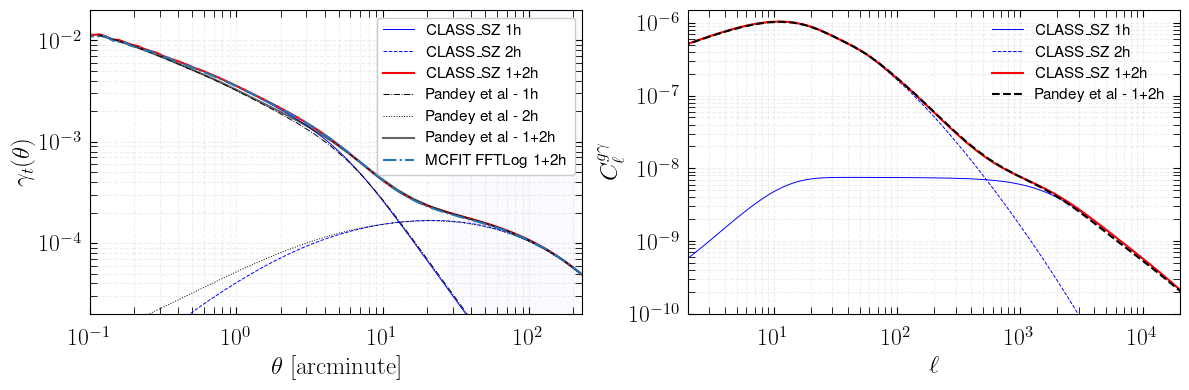

In [48]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r'$\theta$ $\mathrm{[arcminute]}$',size=title_size)
ax.set_ylabel(r'$\gamma_t(\theta)$',size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(2e-5,2e-2)
ax.set_xlim(1e-1,2.3e2)
ax.plot(gamma_t_thetas,(1.+m_gammat)*gamma_t_1h,label='CLASS_SZ 1h',c='b',ls='-',lw=0.7)
ax.plot(gamma_t_thetas,(1.+m_gammat)*gamma_t_2h,label='CLASS_SZ 2h',c='b',ls='--',lw=0.7)
ax.plot(gamma_t_thetas,(1.+m_gammat)*(gamma_t_2h+gamma_t_1h),label='CLASS_SZ 1+2h',c='r')
# th_z21, gammat_z21 = np.loadtxt(path_to_class_sz+'class_sz_auxiliary_files/gammat_1_3.txt',unpack=True)
# ax.plot(th_z21,gammat_z21,label='Zacharegkas et al 21 - Data',marker='o',c='k',ls='None')
# th_z21, gammat_z21 = np.loadtxt(path_to_class_sz+'class_sz_auxiliary_files/gammat_1_3_bf.txt',unpack=True)
# ax.plot(th_z21,gammat_z21,label='Zacharegkas et al 21 - Best-Fit',ls='-',c='k')


th_z21, gammat_z21_1h, gammat_z21_2h, gammat_z21_tot  = np.loadtxt('/Users/boris/Downloads/gammat_bin14_v3.txt',unpack=True)
ax.plot(th_z21,gammat_z21_1h,label='Pandey et al - 1h',c='k',ls='-.',lw=0.7)
ax.plot(th_z21,gammat_z21_2h,label='Pandey et al - 2h',c='k',ls=':',lw=0.7)
ax.plot(th_z21,gammat_z21_tot,label='Pandey et al - 1+2h',c='k',ls='-',alpha=0.6)

ax.plot(theta,G/2./np.pi,label='MCFIT FFTLog 1+2h',ls='-.')
# ax.plot(theta,G2h/2./np.pi,label='MCFIT FFTLog 2h',ls='--')

ax.axvspan(28,2.3e2,alpha=0.02,color='b')

ax.legend(loc=0,ncol = 1,frameon=True,framealpha=1,fontsize=11)


ax = ax2
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r'$\ell$',size=title_size)
ax.set_ylabel(r'$C_\ell^{g\gamma}$',size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-10,1.5e-6)
ax.set_xlim(2.,2e4)
fac = cl_g_gamma_ell*(cl_g_gamma_ell+1.)/2./np.pi
ax.plot(cl_g_gamma_ell,cl_g_gamma_1h/fac,label='CLASS_SZ 1h',c='b',ls='-',lw=0.7)
ax.plot(cl_g_gamma_ell,cl_g_gamma_2h/fac,label='CLASS_SZ 2h',c='b',ls='--',lw=0.7)
ax.plot(cl_g_gamma_ell,cl_g_gamma_1h/fac+cl_g_gamma_2h/fac,label='CLASS_SZ 1+2h',c='r')



th_z21,gammat_z21_tot  = np.loadtxt('/Users/boris/Downloads/Clgk_bin14_pipe.txt',unpack=True)

# ax.plot(th_z21,gammat_z21_1h,label='Shivam - 1h',c='k',ls='-.')
# ax.plot(th_z21,gammat_z21_2h,label='Shivam - 2h',c='k',ls='--')
ax.plot(th_z21,gammat_z21_tot,label='Pandey et al - 1+2h',c='k',ls='--')

ax.legend(loc=0,ncol = 1,frameon=False,fontsize=11)

fig.tight_layout()
# fig.suptitle('Tangential Shear DES/Zacharegkas et al Model',fontsize=16)
# fig.tight_layout()
plt.savefig('figures/class_sz_tangential_shear_DES_pandey.pdf')